In [2]:
from PipeEnv import PipeHeaterSafeEnvGymnasium
from stable_baselines3 import PPO, SAC
from params import *

env = PipeHeaterSafeEnvGymnasium(params, Tinlet=15, Tset=85, T_ext=20, dt=10.0, t_final=3600)

model = SAC("MlpPolicy", env, verbose=1, tensorboard_log="./tensorboard/")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [4]:
model.learn(total_timesteps=150_000, tb_log_name="SAC_pipeheater")  # adjust for convergence

Logging to ./tensorboard/SAC_pipeheater_30
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 360       |
|    ep_rew_mean     | -7.32e+04 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 115       |
|    time_elapsed    | 12        |
|    total_timesteps | 1440      |
| train/             |           |
|    actor_loss      | 1.29e+03  |
|    critic_loss     | 6.28e+03  |
|    ent_coef        | 1.24      |
|    ent_coef_loss   | -0.309    |
|    learning_rate   | 0.0003    |
|    n_updates       | 1339      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 360       |
|    ep_rew_mean     | -7.33e+04 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 113       |
|    time_elapsed    | 25        |
|    total_timesteps | 2880      |
| train/             |           |
|    actor_l

In [36]:
model.save("sac_pipeheater_model")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


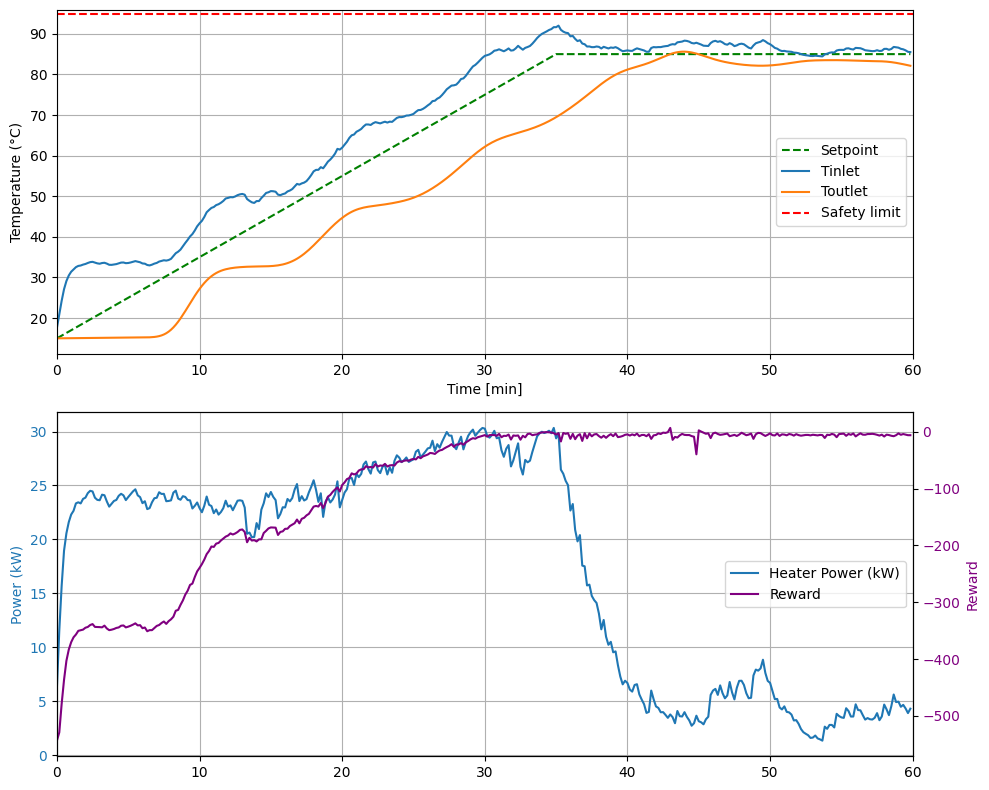

✅ Results saved to simulation_results.csv


In [4]:
env = PipeHeaterSafeEnvGymnasium(params, Tinlet=15, Tset=85, T_ext=20, dt=10.0, t_final=3600, ramped = True)

model = SAC.load("sac_pipeheater_model", env=env)

# model.load("sac_pipeheater_model")


obs, _ = env.reset()
Tin_hist, Tout_hist, P_hist, R_list = [], [], [], []
T_set_list = []
last_act = 0.0
alpha = 0.2

for _ in range(env.steps):
    act, _ = model.predict(obs)
    action = alpha*act + (1-alpha)*last_act
    last_act= action
    obs, reward, terminated, truncated, _ = env.step(action)
    Tin_hist.append(obs[0])
    Tout_hist.append(obs[1])
    P_hist.append(action[0])
    R_list.append(reward)
    T_set_list.append(obs[2]+obs[0])

import matplotlib.pyplot as plt
import pandas as pd

# Parameters
n_steps = 360          # number of steps
dt = 10                # time step [s]
t_total = n_steps * dt # total duration [s]

# Time vector
time = np.arange(0, t_total, dt)   # length = 360, goes 0 → 3590
# or in minutes if you prefer:
time_min = time / 60
# Ramp parameters
T_start = 15
T_end = 85
ramp_steps = 180    # first 30 min
# Temperature vector
# Build temperature profile
T_ramp = np.linspace(T_start, T_end, ramp_steps)
T_plateau = np.full(n_steps - ramp_steps, T_end)
Tset = np.concatenate([T_ramp, T_plateau])
# Create a figure with two subplots (vertically stacked)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# --- Top subplot: Temperature ---
ax1.plot(time_min,T_set_list, color="green", linestyle="--", label="Setpoint")

ax1.plot(time_min,Tin_hist, label="Tinlet", color="C0")
ax1.plot(time_min,Tout_hist, label="Toutlet", color="C1")
ax1.axhline(95, color="red", linestyle="--", label="Safety limit")
ax1.set_ylabel("Temperature (°C)")
ax1.set_xlabel("Time [min]")
ax1.set_xlim(0,60)
ax1.legend(loc="right")
ax1.grid(True)

# --- Bottom subplot: Power and Reward ---
# Left y-axis: Heater Power
ax3 = ax2
line1, = ax3.plot(time_min,P_hist, color="C0", label="Heater Power (kW)")
ax3.set_ylabel("Power (kW)", color="C0")
ax3.tick_params(axis="y", labelcolor="C0")
ax3.grid(True)

# Right y-axis: Reward
ax4 = ax3.twinx()
line2, = ax4.plot(time_min,R_list, color="purple", label="Reward")
ax4.set_ylabel("Reward", color="purple")
ax4.tick_params(axis="y", labelcolor="purple")
ax4.set_xlim(0,60)

# Combine legends for the bottom subplot
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax3.legend(lines, labels, loc="right")

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("images/ramp_RL_results.png", dpi=300, bbox_inches="tight")
plt.show()
time_min = np.arange(0, len(Tin_hist), 1)/6.0

# ---- save results to CSV ----
df = pd.DataFrame({
    "time_min": time_min,
    "Tinlet": Tin_hist,
    "Toutlet": Tout_hist,
    "HeaterPower_kW": P_hist,
    "Reward": R_list
})
df.to_csv("results/ramp_RL_results.csv", index=False)

print("✅ Results saved to simulation_results.csv")
